In [1]:
from transformers import AutoTokenizer
from transformers import T5ForConditionalGeneration

model = "t5-small"
t5: T5ForConditionalGeneration = T5ForConditionalGeneration.from_pretrained(
        model
    )

tokenizer =  AutoTokenizer.from_pretrained(model)

In [2]:
from transformers import T5ForConditionalGeneration
from transformers.models.t5.modeling_t5 import T5Attention, T5Config, T5Block
from copy import deepcopy
from typing import List
from collections import defaultdict
t5: T5ForConditionalGeneration = T5ForConditionalGeneration.from_pretrained(
        "t5-small"
    )

def get_tf_attention_dict(module,kv_heads:int=4):
    transfer_to_gqa: List[str] = ["encoder","decoder","EncDecAttention"]
    tf_attention_dict = defaultdict(list)
    def convert_t5_to_gqa(module, kv_heads: int,similarity_flag:bool=False,inplace: bool = False,curr_name:str=''):
        """Get the list of attention modules based on the flag about encoder, decoder or cross-attention

        Args:
            module: Transformer module/unit
            kv_heads (int): Number of key-value heads
            similarity_flag (bool, optional): Similarity GQA flag. Defaults to False.
            inplace (bool, optional): inplace replace the model with GQA. Defaults to False.

        Returns:
            _type_: _description_
        """
        if isinstance(module, T5Attention) and similarity_flag:
            tf_attention_dict[curr_name].append(module)

        out = module if inplace else deepcopy(module)
        for name, child in out.named_children():
            if name in transfer_to_gqa:
                curr_name = name
                similarity_flag = True
            out._modules[name] = convert_t5_to_gqa(child, kv_heads=kv_heads,similarity_flag=similarity_flag, inplace=True,curr_name=curr_name)
        return out

    convert_t5_to_gqa(module,kv_heads=kv_heads)
    return tf_attention_dict

In [3]:
tf_attention_dict = get_tf_attention_dict(t5)

In [4]:
print(len(tf_attention_dict['encoder']))
print(len(tf_attention_dict['decoder']))
print(len(tf_attention_dict['EncDecAttention']))

6
6
6


In [5]:
import torch
import torch.nn.functional as F

def get_sim_score(query_heads_attn):
    query_heads = torch.tensor_split(query_heads_attn,8,dim=1)
    sim_keys = ['kv_heads_'+str(i) for i in range(0,len(query_heads)//2)]
    sim_keys_dict = {key: 0.0 for key in sim_keys}
    for i in range(0,len(query_heads)-1,2):
        vec1 = query_heads[i]
        vec2 = query_heads[i+1]
        # Flatten the vectors
        vec1_flat = vec1.reshape(-1).unsqueeze(0)
        vec2_flat = vec2.reshape(-1).unsqueeze(0)
        # print(vec1_flat.shape)

        # Calculate cosine similarity using PyTorch's F.cosine_similarity
        cosine_sim = F.cosine_similarity(vec1_flat, vec2_flat).item()
        if i==0: dict_name='0'
        elif i==2: dict_name='1'
        elif i==4:dict_name='2'
        elif i==6:dict_name='3'

        sim_keys_dict[f'kv_heads_{dict_name}']=[cosine_sim]
    return sim_keys_dict  

In [6]:
gqa_list = ['encoder','decoder','EncDecAttention']
all_similarities_dict = defaultdict(list)

for attn_name in gqa_list:
    #attn_name is encoder, decoder or cross-attention
    for attn_layer in tf_attention_dict[attn_name]:
        all_similarities_dict[attn_name].append(get_sim_score(attn_layer.q.weight.data))

In [7]:
len(all_similarities_dict['EncDecAttention'])

6

In [8]:
temp_similarities_dict = all_similarities_dict

In [9]:
for attn_name,curr_attn_dict in all_similarities_dict.items():

    for idx,attn_layer in enumerate(curr_attn_dict):
        for attn_heads,sim_scores in attn_layer.items():
            curr_val = temp_similarities_dict[attn_name][idx][attn_heads]
            all_similarities_dict[attn_name][idx][attn_heads].extend(curr_val)

In [10]:
len(all_similarities_dict['encoder'])

6

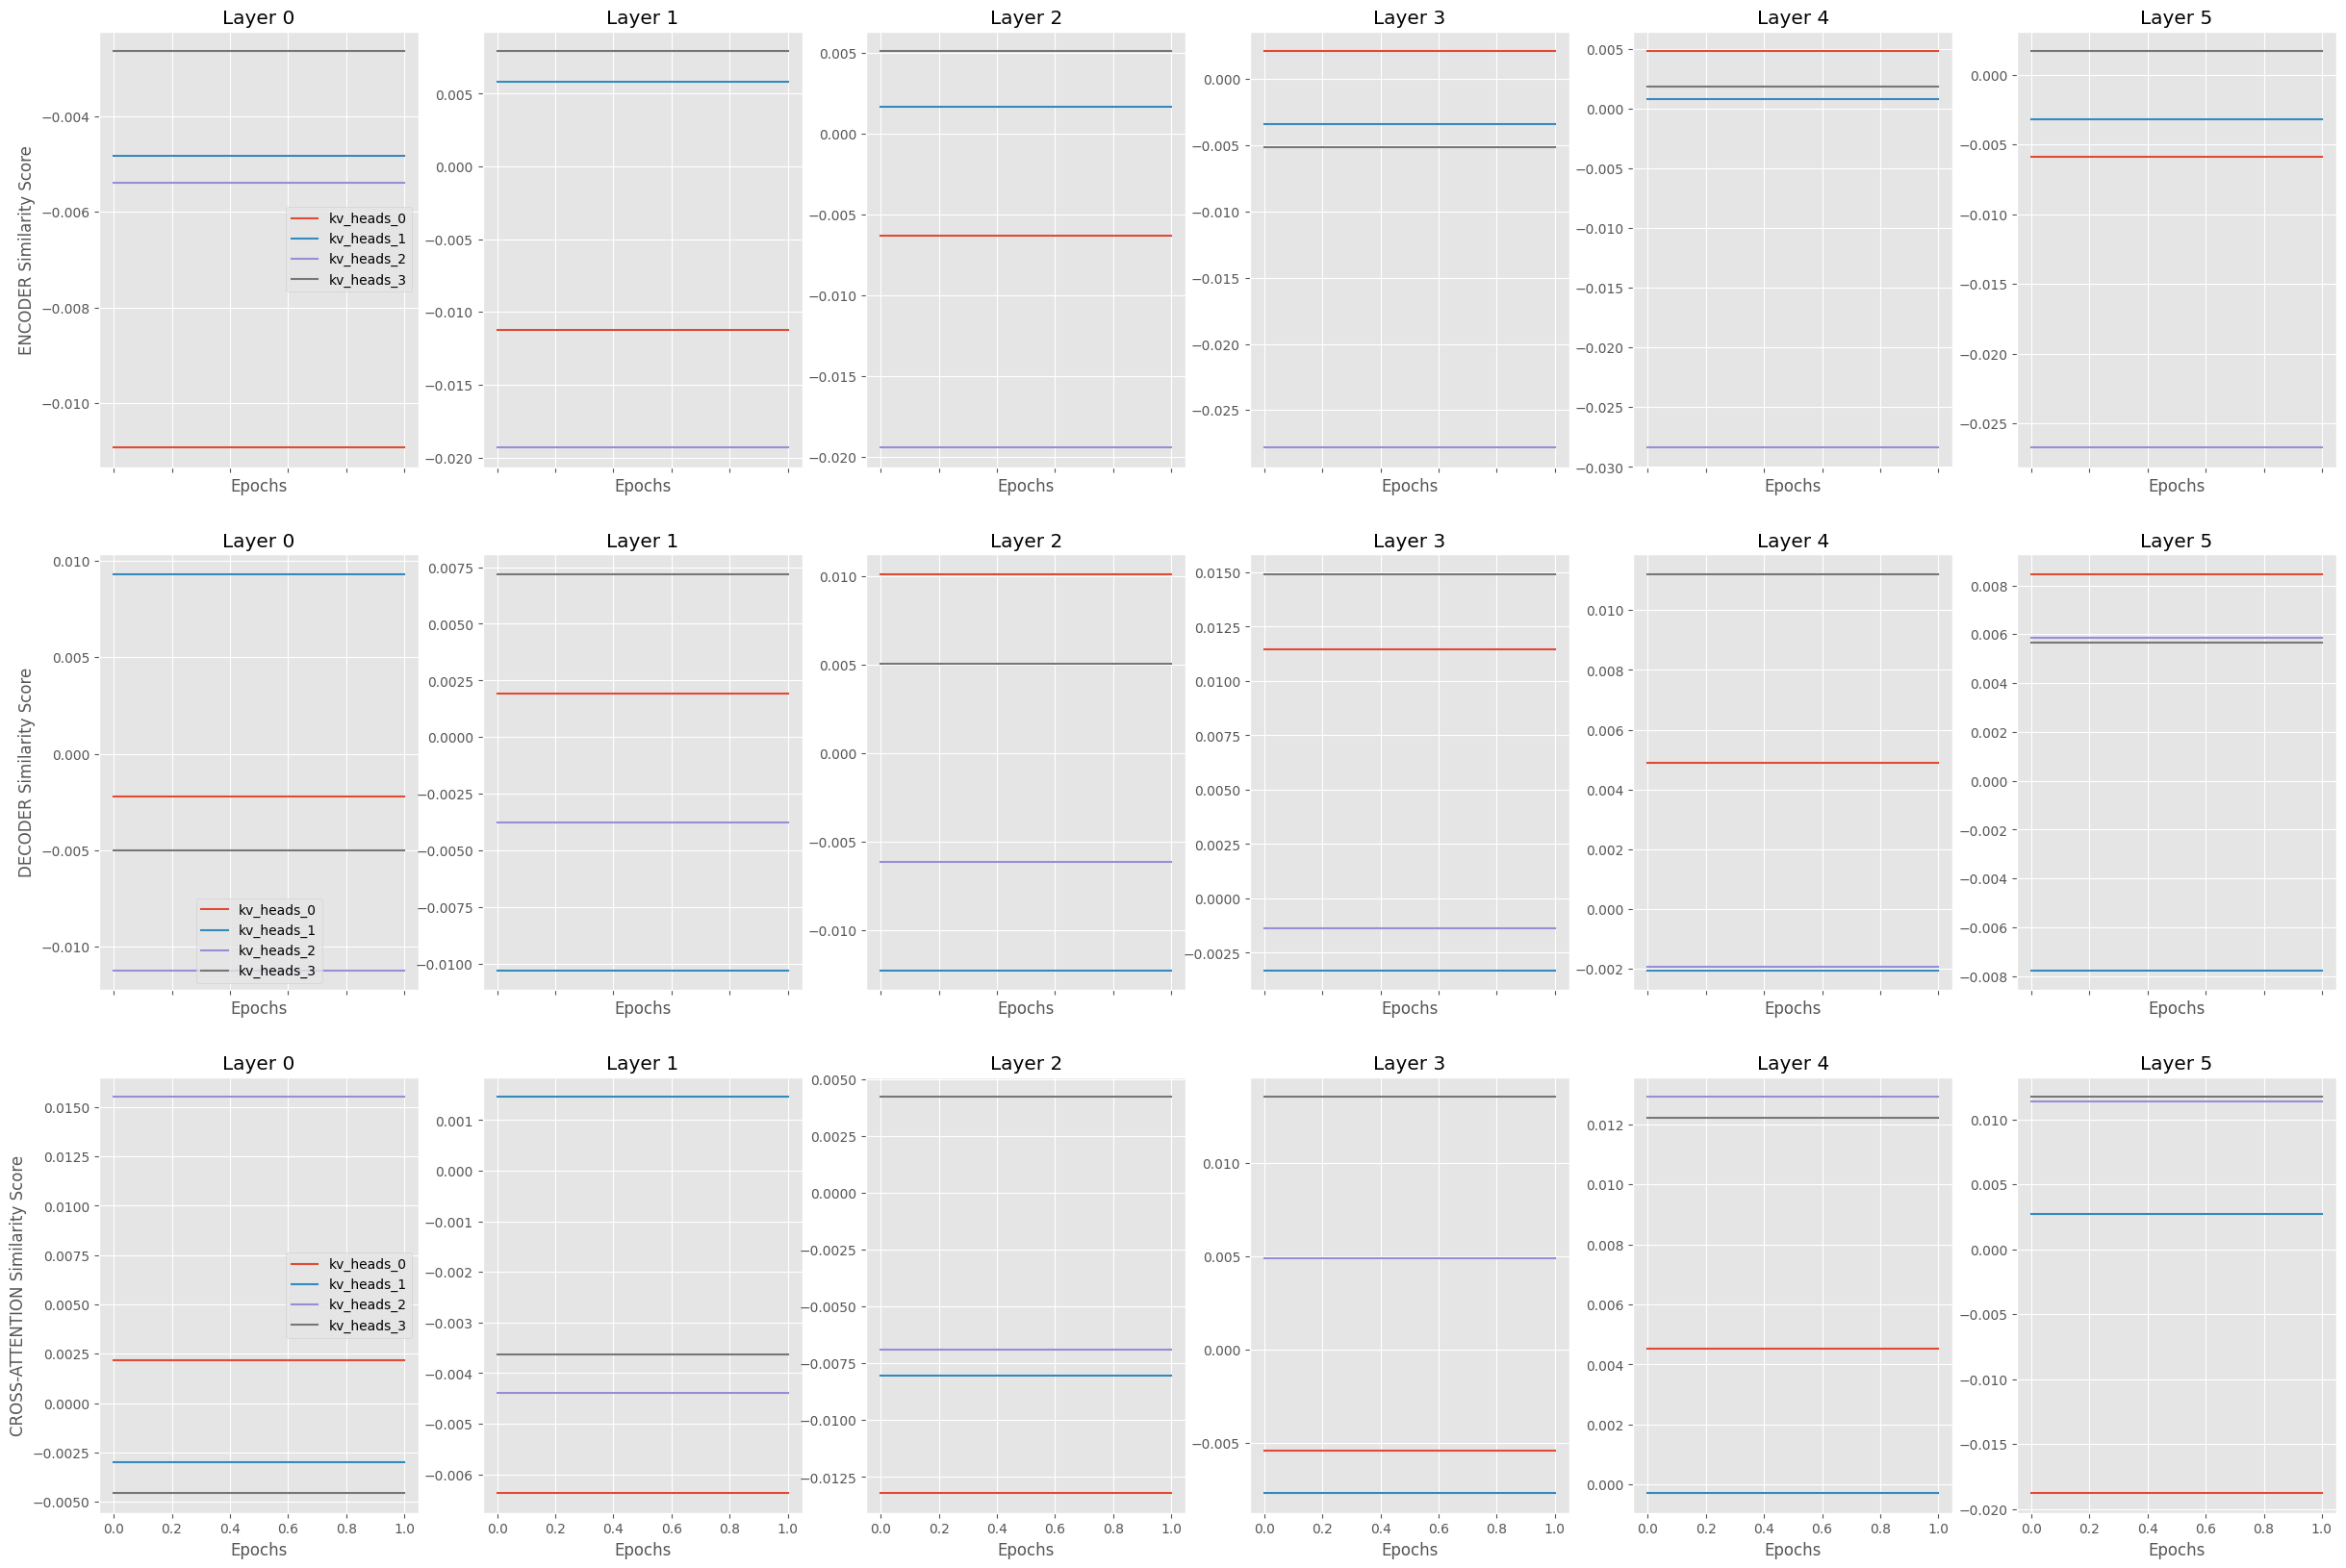

In [11]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
num_cols = len(all_similarities_dict[gqa_list[0]])
key_vals = all_similarities_dict.keys()
fig, ax = plt.subplots(3, 6, sharex=True,figsize=(30, 20))

fax = ax.ravel()
for i in range(6):
    for j in range(4):
        fax[i].plot(all_similarities_dict['encoder'][i][f'kv_heads_{j}'],label=f'kv_heads_{j}')
    fax[i].set_xlabel("Epochs")
    fax[i].set_title(f'Layer {i}')
fax[0].set_ylabel("ENCODER Similarity Score")
fax[0].legend()
    
for i in range(6,12):
    for j in range(4):
        fax[i].plot(all_similarities_dict['decoder'][i-6][f'kv_heads_{j}'],label=f'kv_heads_{j}')
    fax[i].set_xlabel("Epochs")
    fax[i].set_title(f'Layer {i-6}')
fax[6].set_ylabel("DECODER Similarity Score")
fax[6].legend()

for i in range(12,18):
    for j in range(4):
        fax[i].plot(all_similarities_dict['EncDecAttention'][i-12][f'kv_heads_{j}'],label=f'kv_heads_{j}')
    fax[i].set_xlabel("Epochs")
    fax[i].set_title(f'Layer {i-12}')
fax[12].set_ylabel("CROSS-ATTENTION Similarity Score")
fax[12].legend()

In [12]:
def tokenize_function_X(data):
    tokenizer =  AutoTokenizer.from_pretrained(model,truncation=True,max_length=512,padding=True)
    return tokenizer(data["article"],truncation=True,max_length=512)
def tokenize_function_Y(data):
    tokenizer =  AutoTokenizer.from_pretrained(model,truncation=True,max_length=512,padding=True)
    return tokenizer(data["highlights"],truncation=True,max_length=512)

In [11]:
from datasets import load_dataset

data_dir = "data"
cnn_data_train = load_dataset("cnn_dailymail",data_dir=data_dir,split="train[:5%]")
cnn_data_test = load_dataset("cnn_dailymail",data_dir=data_dir,split="test[:100%]")
cnn_data_val = load_dataset("cnn_dailymail",data_dir=data_dir,split="validation[:100%]")

In [12]:
# batch_size = 1000
# X_train = cnn_data_train.map(tokenize_function_X,batched=True,batch_size=batch_size,remove_columns=['article','highlights','id'])
# y_train = cnn_data_train.map(tokenize_function_Y,batched=True,batch_size=batch_size,remove_columns=['article','highlights','id'])

# X_val = cnn_data_val.map(tokenize_function_X,batched=True,batch_size=batch_size,remove_columns=['article','highlights','id'])
# y_val = cnn_data_val.map(tokenize_function_Y,batched=True,batch_size=batch_size,remove_columns=['article','highlights','id'])

# X_test = cnn_data_test.map(tokenize_function_X,batched=True,batch_size=batch_size,remove_columns=['article','highlights','id'])
# y_test = cnn_data_test.map(tokenize_function_Y,batched=True,batch_size=batch_size,remove_columns=['article','highlights','id'])

In [13]:
prefix = "summarize: "
max_input_length = 512
max_target_length = 128
def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True,padding=True)

    # Setup the tokenizer for targets
    labels = tokenizer(text_target=examples["highlights"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [14]:
batch_size = 1000
tokenized_datasets_train = cnn_data_train.map(preprocess_function, batched=True,remove_columns=['article','highlights','id'],batch_size=batch_size)
tokenized_datasets_val = cnn_data_val.map(preprocess_function, batched=True,remove_columns=['article','highlights','id'],batch_size=batch_size)
tokenized_datasets_test = cnn_data_test.map(preprocess_function, batched=True,remove_columns=['article','highlights','id'],batch_size=batch_size)

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

In [15]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from torch.utils.data import DataLoader
data_collator = DataCollatorForSeq2Seq(tokenizer, model=t5)

train_dataloader = DataLoader(tokenized_datasets_train, shuffle=True, batch_size=8,collate_fn=data_collator)
eval_dataloader = DataLoader(tokenized_datasets_val, batch_size=8,collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_datasets_test, batch_size=8,collate_fn=data_collator)

In [16]:
for batch in train_dataloader:
    break

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [80]:
from torch.optim import AdamW
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(t5.parameters(), lr=5e-5)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [17]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
t5.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [18]:
from evaluate import load
metric = load("rouge")

In [2]:
d = {'rouge1': 11.382,
        'rouge2': 3.7489,
        'rougeL': 7.4471,
        'rougeLsum': 10.2839,
        'gen_len': 469.5}

{k:[] for k in d.keys()}

{'rouge1': [], 'rouge2': [], 'rougeL': [], 'rougeLsum': [], 'gen_len': []}

In [82]:
from tqdm.auto import tqdm
gqa_list = ['encoder','decoder','EncDecAttention']

progress_bar = tqdm(range(num_training_steps))
tf_attention_dict = get_tf_attention_dict(t5)
all_similarities_dict = defaultdict()
for attn_name in gqa_list:
    #attn_name is encoder, decoder or cross-attention
    for attn_layer in tf_attention_dict[attn_name]:
        all_similarities_dict[attn_name].append(get_sim_score(attn_layer.q.weight.data))

for epoch in range(num_epochs):
    t5.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = t5(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    
    t5.eval()
    tf_attention_dict = get_tf_attention_dict(t5)
    curr_similarities_dict = defaultdict(list)

    for attn_name in gqa_list:
        #attn_name is encoder, decoder or cross-attention
        for attn_layer in tf_attention_dict[attn_name]:
            curr_similarities_dict[attn_name].append(get_sim_score(attn_layer.q.weight.data))
    
    for attn_name,curr_attn_dict in all_similarities_dict.items():

        for idx,attn_layer in enumerate(curr_attn_dict):
            for attn_heads,sim_scores in attn_layer.items():
                curr_val = curr_similarities_dict[attn_name][idx][attn_heads]
                all_similarities_dict[attn_name][idx][attn_heads].extend(curr_val)
    
    eval_dict_list = []
    for eval_batch in eval_dataloader:
        eval_dict_list.append(compute_metrics(eval_batch))
    # {'rouge1': 11.382,
    # 'rouge2': 3.7489,
    # 'rougeL': 7.4471,
    # 'rougeLsum': 10.2839,
    # 'gen_len': 469.5}
    key_names = eval_dict_list[0].keys()
    average_dict = {k:get_avg(eval_dict_list,k) for k in key_names}

def get_avg(eval_dict_list,key_name:str):
    return sum(d[key_name] for d in eval_dict_list) / len(eval_dict_list)

  0%|          | 0/5385 [00:00<?, ?it/s]

In [64]:
l = [{'h':1,'g':2},{'h':2,'g':3},{'h':21,'g':5}]

average_dict = {'h': sum(d['h'] for d in l) / len(l), 'g': sum(d['g'] for d in l) / len(l)}
average_dict

{'h': 8.0, 'g': 3.3333333333333335}

In [23]:
for batch in eval_dataloader:
    break

In [19]:
device='cuda:0'
t5.eval()
batch = {k: v.to(device) for k, v in batch.items()}
outputs = t5.generate(batch)

In [22]:
outputs.keys()

odict_keys(['loss', 'logits', 'past_key_values', 'encoder_last_hidden_state'])

In [59]:
import nltk
import numpy as np

def compute_metrics(eval_batch):
    predictions, labels = eval_batch['input_ids'],eval_batch['labels']
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    # Note that other metrics may not have a `use_aggregator` parameter
    # and thus will return a list, computing a metric for each sentence.
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True, use_aggregator=True)
    # Extract a few results
    result = {key: value * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [60]:
compute_metrics(batch)

{'rouge1': 11.382,
 'rouge2': 3.7489,
 'rougeL': 7.4471,
 'rougeLsum': 10.2839,
 'gen_len': 469.5}

In [28]:
text = ["""
In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won't do what they're told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less likely to follow directions, according to Leifman. So, they end up on the ninth floor severely mentally disturbed, but not getting any real help because they're in jail. We toured the jail with Leifman. He is well known in Miami as an advocate for justice and the mentally ill. Even though we were not exactly welcomed with open arms by the guards, we were given permission to shoot videotape and tour the floor. Go inside the 'forgotten floor' » . At first, it's hard to determine where the people are. The prisoners are wearing sleeveless robes. Imagine cutting holes for arms and feet in a heavy wool sleeping bag -- that's kind of what they look like. They're designed to keep the mentally ill patients from injuring themselves. That's also why they have no shoes, laces or mattresses. Leifman says about one-third of all people in Miami-Dade county jails are mentally ill. So, he says, the sheer volume is overwhelming the system, and the result is what we see on the ninth floor. Of course, it is a jail, so it's not supposed to be warm and comforting, but the lights glare, the cells are tiny and it's loud. We see two, sometimes three men -- sometimes in the robes, sometimes naked, lying or sitting in their cells. "I am the son of the president. You need to get me out of here!" one man shouts at me. He is absolutely serious, convinced that help is on the way -- if only he could reach the White House. Leifman tells me that these prisoner-patients will often circulate through the system, occasionally stabilizing in a mental hospital, only to return to jail to face their charges. It's brutally unjust, in his mind, and he has become a strong advocate for changing things in Miami. Over a meal later, we talk about how things got this way for mental patients. Leifman says 200 years ago people were considered "lunatics" and they were locked up in jails even if they had no charges against them. They were just considered unfit to be in society. Over the years, he says, there was some public outcry, and the mentally ill were moved out of jails and into hospitals. But Leifman says many of these mental hospitals were so horrible they were shut down. Where did the patients go? Nowhere. The streets. They became, in many cases, the homeless, he says. They never got treatment. Leifman says in 1955 there were more than half a million people in state mental hospitals, and today that number has been reduced 90 percent, and 40,000 to 50,000 people are in mental hospitals. The judge says he's working to change this. Starting in 2008, many inmates who would otherwise have been brought to the "forgotten floor" will instead be sent to a new mental health facility -- the first step on a journey toward long-term treatment, not just punishment. Leifman says it's not the complete answer, but it's a start. Leifman says the best part is that it's a win-win solution. The patients win, the families are relieved, and the state saves money by simply not cycling these prisoners through again and again. And, for Leifman, justice is served. E-mail to a friend ."""]

In [29]:
input_ids = tokenizer(
    f"summarize: {text}", return_tensors="pt"
).input_ids  # Batch size 1
outputs = t5.generate(input_ids.to(device),max_new_tokens=500,num_beams=5,top_p=0.8,do_sample=True)
output_decode = tokenizer.decode(outputs[0], skip_special_tokens=True)

In [34]:
for batch in eval_dataloader:
    break

In [37]:
# batch['input_ids']
outputs = t5.generate(batch['input_ids'].to(device),max_new_tokens=500,num_beams=5,top_p=0.8,do_sample=True)
outputs

torch.Size([8, 83])

In [44]:
output_decode = tokenizer.batch_decode(outputs, skip_special_tokens=True)

In [45]:
output_decode

['transplants are taking five surgeons, a covey of physician assistants, nurses and anesthesiologists. they are extracting six kidneys from donors and implanting them into six recipients. the chain of surgeries is to be wrapped up Friday.',
 'a new domestic television and media rights deal with MLS is worth $700 million over eight years. the new season is the first of a new domestic television and media rights deal with FOX, ESPN and Univision. the new season is the first of a new domestic television and media rights deal with FOX, ESPN and Univision.',
 'bafetimbi Gomis is now "feeling well" after collapsing during Swansea\'s 3-2 defeat at white hart lane. the 29-year-old has a history of fainting and is now "feeling well" he spent the night in hospital as a precaution, according to manager garry monk.',
 "former world no 1 says frustration was a 'thousand of the moment' he says he 'didn't need a 3iron for the rest of the round' the four-time major winner finished with a second round 

In [50]:
batch['labels'].shape

torch.Size([8, 67])

In [51]:
batch['input_ids'].shape

torch.Size([8, 512])

In [58]:
import numpy as np
labels = batch['labels'].numpy()
labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
tokenizer.batch_decode(labels,skip_special_tokens=True)

['Zully Broussard decided to give a kidney to a stranger. A new computer program helped her donation spur transplants for six kidney patients.',
 'The 20th MLS season begins this weekend. League has changed dramatically since its inception in 1996. Some question whether rules regarding salary caps and transfers need to change.',
 'Bafetimbi Gomis collapses within 10 minutes of kickoff at Tottenham. But he reportedly left the pitch conscious and wearing an oxygen mask. Gomis later said that he was "feeling well" The incident came three years after Fabrice Muamba collapsed at White Hart Lane.',
 'Rory McIlroy throws club into water at WGC Cadillac Championship. Northern Irishman frustrated after pulling shot into water hazard.',
 "Cayman Naib, 13, hasn't been heard from since Wednesday. Police, family, volunteers search for eighth-grader.",
 'Ruben Navarrette: Schilling deserves praise for taking on online haters for offensive comments about his daughter. Navarrette: In protecting his ch

## LEARNING BASED POOLING

In [ ]:
# (512,512) --> transpose --> (512,512) --> tensor split --> (512,64) 8 times
# Take the first two, w1*(512,64) + w2*(512,64) = (512,64)
# Need to initialize 8 parameters for each head and multiply them. Then add along axis = 1
